# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [15]:
# import libraries
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession

from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, TimestampType
from pyspark.sql.types import IntegerType, DateType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum
from pyspark.sql import Window

from datetime import datetime

from pyspark.sql.types import IntegerType
from pyspark.ml.feature import RegexTokenizer, VectorAssembler

from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, avg, lit
from pyspark.sql.functions import explode, min, max, split, stddev, countDistinct
from pyspark.sql.functions import to_date, datediff, current_timestamp

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from time import time

In [16]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("churn-prediction") \
    .getOrCreate()
    
spark.sparkContext.getConf().getAll()

[('spark.dynamicAllocation.enabled', 'false'),
 ('spark.eventLog.enabled', 'true'),
 ('spark.network.crypto.keyLength', '256'),
 ('spark.shuffle.service.enabled', 'false'),
 ('spark.network.crypto.enabled', 'true'),
 ('spark.driver.memory', '4g'),
 ('spark.executor.extraClassPath',
  '/usr/local/share/jupyter/kernels/scala/lib/*:/home/spark/shared/user-libs/spark2/*:/home/spark/shared/user-libs/common/*:/home/spark/shared/user-libs/connectors/*:/opt/ibm/connectors/db2/*:/opt/ibm/connectors/others-db-drivers/*:/opt/ibm/third-party/libs/spark2/*:/opt/ibm/third-party/libs/common/*:/opt/ibm/third-party/libs/connectors/*'),
 ('spark.authenticate.enableSaslEncryption', 'true'),
 ('spark.ui.port', '4040'),
 ('spark.ui.killEnabled', 'false'),
 ('spark.hadoop.fs.stocator.glob.bracket.support', 'true'),
 ('spark.driver.extraJavaOptions',
  ' -Dderby.system.home=/home/spark/.local/share/jupyter/runtime/kernel-3fcd5429-c474-402d-9670-5a09899a97fc-20200409_115602 -Dlog4j.logFile=/home/spark/shared/

In [17]:
spark

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

### Comment: We will also perform some data exploration here

In [18]:
import ibmos2spark
# @hidden_cell
credentials = {
    'endpoint': 'https://s3.eu-geo.objectstorage.service.networklayer.com',
    'service_id': 'iam-ServiceId-d4133564-626b-417e-a51b-590db2a58dca',
    'iam_service_endpoint': 'https://iam.eu-gb.bluemix.net/oidc/token',
    'api_key': 'MY0HDCuUq4FBxUekaDk7x6HI3PsYEZaxjt0xOSqhPX9i'
}

configuration_name = 'os_065589b5fbc44670bc2c61d4c2840804_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
# Since JSON data can be semi-structured and contain additional metadata, it is possible that you might face issues with the DataFrame layout.
# Please read the documentation of 'SparkSession.read()' to learn more about the possibilities to adjust the data loading.
# PySpark documentation: http://spark.apache.org/docs/2.0.2/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.json

df_data_1 = spark.read.json(cos.url('medium-sparkify-event-data.json', 'sparkify-donotdelete-pr-i2mfuoqa2gxtrm'))
df_data_1.take(5)

[Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293'),
 Row(artist="John Brown's Body", auth='Logged In', firstName='Sawyer', gender='M', itemInSession=74, lastName='Larson', length=380.21179, level='free', location='Houston-The Woodlands-Sugar Land, TX', method='PUT', page='NextSong', registration=1538069638000, sessionId=97, song='Bulls', status=200, ts=1538352025000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='98'),
 Row(artist='Afroman', auth='Logged In', firstName='Maverick', gender='M', 

In [19]:
user_log = df_data_1

In [20]:
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



### Cleaning

### Some cleaning happens here:

We would like to replace empty userId strings by actual NAN values

In [21]:
user_log = user_log.replace(to_replace='', value=None, subset=['userId'])

### Sort by UserID, and then by Timestamp (ascending)

In [22]:
user_log = user_log.orderBy(["userId", "ts"], ascending=[1, 1])

### Convert from timestamp to datetime, to see exactly how wide a timeline we are covering

We faced two issues here; first, our ts field is in miliseconds, not seconds, that has an easy solution though. Second is actually transforming the timestamp in second to datetime.

https://stackoverflow.com/questions/51983037/convert-from-timestamp-to-specific-date-in-pyspark

In [23]:
#transform from miliseconds to seconds

user_log = user_log.withColumn('ts_in_seconds', user_log.ts/1000)
user_log = user_log.withColumn('registration_in_seconds', user_log.registration/1000)

In [24]:
# Create a function that returns the desired string from a timestamp 
def format_timestamp(ts):
    return datetime.fromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')

# Create the UDF
format_timestamp_udf = udf(lambda x: format_timestamp(x))

# Finally, apply the function to each element of the 'timestamp' column
user_log = user_log.withColumn('datetime', format_timestamp_udf(user_log['ts_in_seconds']))
user_log = user_log.withColumn('registration_datetime', format_timestamp_udf(user_log['registration_in_seconds']))

In [25]:
max_date = user_log.where(~user_log.datetime.isNull()).agg({"datetime": "max"}).collect()[0][0]
min_date = user_log.where(~user_log.datetime.isNull()).agg({"datetime": "min"}).collect()[0][0]
print('Our data covers from {} to {}'.format(min_date, max_date))

Our data covers from 2018-10-01 00:00:11 to 2018-12-01 00:01:06


### Example of log for onse user (userId == XXX)

In [26]:
user_log.where(col('userId') == 101).where(col('sessionId')== 635).\
select(['sessionId','datetime','page','level','artist','song']).take(10)

[]

### Relationship between AUTH and PAGE

From what we see below: 

* **Logged in** corresponds to the normal usage of the application, with users navigating through different sections of the app, playing songs, and finally returning to home or logging out.

* Logged out: about, help, error (404), home and login. We do not have userId either when users are logged out from the application.

* Guests only can access the following pages: register, about, submit registration, help, home and error (page 404). As we do not have userID for guest or any other mean to track them if they afterward become users, this auth is of no use for us. Probably if we see a guest registering, and a new user id popping up right afterwards we could relate them, by timestamp, but I do not think this is needed for our analysis just yet.

* auth **Cancelled** corresponds to page 'Cancellation confirmation', which is pretty useful for us to track actual cancellations. They contain userID and User information.

Most interesting one is therefore Logged in, which tells us how each user behaves while using the app

### Lastly, Let's keep just auth=Logged in and Cancelled

This is because all the actions/events we are interested in happens while auth=Logged In, and we define our target as user who have cancelled the service, and they are represented with an entry which has auth=Cancelled

In [27]:
user_log = user_log.where(user_log.auth.isin(['Logged In', 'Cancelled']))

Now we should have our dataset loaded as the **user_log** dataframe. Empty user or sessionids have been removed.  Last but not least, we have also restricted our data to actions while people were logged into the app (cause otherwise we would not have info about the users) and cancellations, which belong to auth - 'cancelled'.

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

### Some general numbers

In [28]:
print('There are {} rows in this dataset.'.format(user_log.count()))
print('Number of different Artists listened to is {}.'.format(user_log.select("artist").dropDuplicates().toPandas().shape[0]))
print('and containing {} different songs'.format(user_log.select("song").dropDuplicates().toPandas().shape[0]))
print('Data from {} different locations'.format(user_log.select("location").dropDuplicates().toPandas().shape[0]))
print('On {} different users'.format(user_log.select("userId").dropDuplicates().toPandas().shape[0]))

There are 528005 rows in this dataset.
Number of different Artists listened to is 21248.
and containing 80293 different songs
Data from 192 different locations
On 448 different users


### Length of Song

In [29]:
print('Numeric Statistics about the length of every session')
user_log.describe('length').show()

Numeric Statistics about the length of every session
+-------+-----------------+
|summary|           length|
+-------+-----------------+
|  count|           432877|
|   mean|248.6645927800736|
| stddev|98.41266955052019|
|    min|          0.78322|
|    max|       3024.66567|
+-------+-----------------+



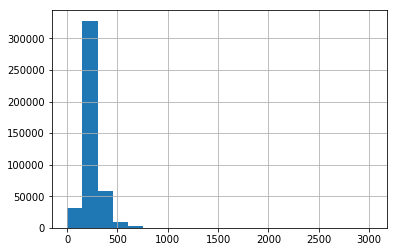

In [30]:
song_length = user_log.where(user_log.length >= 0).select('length').toPandas()
song_length['length'].hist(bins=20)

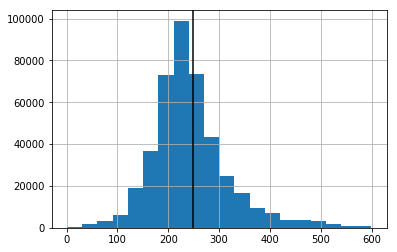

In [31]:
song_length = user_log.where(user_log.length <= 600).select('length').toPandas()
song_length['length'].hist(bins=20)
plt.axvline(x=user_log.agg({"length": "mean"}).collect()[0][0], color='black')

Wow. Such normal. Although we know that there is a long long tail we are filtering out in the viz above, as we can tell by the mean being displaced to the right of the center of the ditribution. But nevertheless, Having a normal distribution for length songs makes sense, and altough we might have some erroneos values for length, they are not biasing this distribution in any way. We may proceed.

### Gender

It might look that gender is uncorrectly filled for some users, but those 'None' entries come from sessions that are not logged.

In [32]:
user_log.groupby("gender").count().collect()

[Row(gender='F', count=225393), Row(gender='M', count=302612)]

### Items in Session

There are extraordinarily large numbers in itemInSessions, but the reason might be as easy as users not logging out in several days from the application and therefore accumulating items for several days.

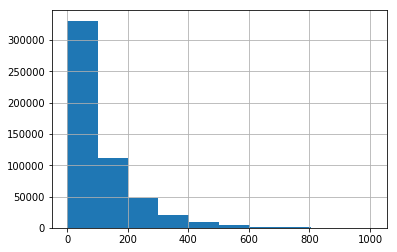

In [33]:
user_log.select('itemInSession').toPandas()['itemInSession'].hist()

### Subscription level

In [34]:
user_log.groupby("level").count().collect()

[Row(level='free', count=109961), Row(level='paid', count=418044)]

### Location

In [35]:
user_log.groupby("location").count().orderBy('count', ascending=False).take(10)

[Row(location='New York-Newark-Jersey City, NY-NJ-PA', count=40156),
 Row(location='Los Angeles-Long Beach-Anaheim, CA', count=34278),
 Row(location='Boston-Cambridge-Newton, MA-NH', count=17574),
 Row(location='Chicago-Naperville-Elgin, IL-IN-WI', count=15194),
 Row(location='San Francisco-Oakland-Hayward, CA', count=11428),
 Row(location='Atlanta-Sandy Springs-Roswell, GA', count=11211),
 Row(location='Phoenix-Mesa-Scottsdale, AZ', count=11184),
 Row(location='Dallas-Fort Worth-Arlington, TX', count=11061),
 Row(location='Denver-Aurora-Lakewood, CO', count=9808),
 Row(location='Houston-The Woodlands-Sugar Land, TX', count=8707)]

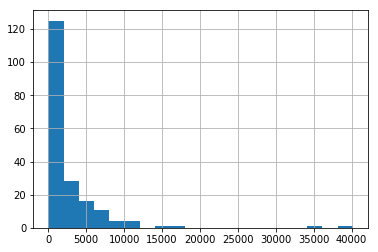

In [36]:
location_count = user_log.groupby("location").count().orderBy('count', ascending=False).toPandas()
location_count['count'].hist(bins=20)

We can see that there are a majority of locations with small population, and then some big cities

### Method

In [37]:
user_log.groupby("method").count().collect()

[Row(method='PUT', count=489128), Row(method='GET', count=38877)]

### Error code 404 and page 'Error' refer to the same entries

In [38]:
user_log.groupby("page").count().collect()

[Row(page='Cancel', count=99),
 Row(page='Submit Downgrade', count=117),
 Row(page='Thumbs Down', count=4911),
 Row(page='Home', count=19089),
 Row(page='Downgrade', count=3811),
 Row(page='Roll Advert', count=7773),
 Row(page='Logout', count=5990),
 Row(page='Save Settings', count=585),
 Row(page='Cancellation Confirmation', count=99),
 Row(page='About', count=1026),
 Row(page='Settings', count=2964),
 Row(page='Add to Playlist', count=12349),
 Row(page='Add Friend', count=8087),
 Row(page='NextSong', count=432877),
 Row(page='Thumbs Up', count=23826),
 Row(page='Help', count=2644),
 Row(page='Upgrade', count=968),
 Row(page='Error', count=503),
 Row(page='Submit Upgrade', count=287)]

In [39]:
user_log.groupby("status").count().collect()

[Row(status=307, count=43902),
 Row(status=404, count=503),
 Row(status=200, count=483600)]

In [40]:
user_log.filter(user_log.auth == 'Cancelled').take(1)

[Row(artist=None, auth='Cancelled', firstName='Brycen', gender='M', itemInSession=435, lastName='Bradley', length=None, level='paid', location='Laurel, MS', method='GET', page='Cancellation Confirmation', registration=1538159495000, sessionId=9, song=None, status=200, ts=1539055364000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='10', ts_in_seconds=1539055364.0, registration_in_seconds=1538159495.0, datetime='2018-10-09 03:22:44', registration_datetime='2018-09-28 18:31:35')]

### Comment: So we did most of our cleaning and exploratory work to this point, so for now we will just focus on defining churn, further explore some features, and create an aggregated dataset to be used in the modelling step

In [41]:
user_log = user_log.withColumn('date', user_log.datetime.cast('date'))
user_log = user_log.withColumn('registration_date', user_log.registration_datetime.cast('date'))

In [42]:
has_churned = udf(lambda val: int(val == 'Cancellation Confirmation'), IntegerType())
user_log = user_log.withColumn("churn", has_churned("page"))

In [43]:
df = user_log.groupby(['userId']).agg({"churn": "sum"})\
.orderBy('sum(churn)', ascending=False).toPandas().rename(columns={'sum(churn)':'has_churned'})

### Seems that a high percentage of our users have churned. That's bad for business, but great for us. this is not an extremely unbalanced problem, which tipically are hard to deal with.

In [44]:
print('Percentage of each class')
df['has_churned'].value_counts()/df.shape[0]

Percentage of each class


0    0.779018
1    0.220982
Name: has_churned, dtype: float64

In [45]:
df.head()

,userId,has_churned
0,124,1
1,51,1
2,132,1
3,100014,1
4,154,1


In [46]:
# we get the UserIDs that have churned at any point in the period covered by our dataset
churn_ids = df.loc[df['has_churned']==1, 'userId'].values
no_churn_ids = df.loc[df['has_churned']==0, 'userId'].values

### Let's compare users who have churned to those who have not

### by length of songs

In [47]:
user_churn = user_log.where(user_log.userId.isin(list(churn_ids)))
user_active = user_log.where(user_log.userId.isin(list(no_churn_ids)))

In [48]:
print('Number of rows in dataframe with users who churned: {}'.format(user_churn.count()))
print('Number of rows in dataframe with users who have not churned: {}'.format(user_active.count()))

Number of rows in dataframe with users who churned: 103646
Number of rows in dataframe with users who have not churned: 424359


Text(0.5, 1.0, 'Song Length for Active Users')

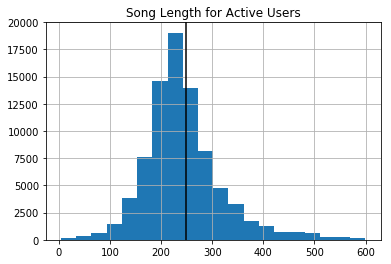

In [49]:
churn_length = user_churn.where(user_log.length <= 600).select('length').toPandas()
churn_length['length'].hist(bins=20)
plt.axvline(x=user_churn.agg({"length": "mean"}).collect()[0][0], color='black')
plt.title('Song Length for Active Users')

Text(0.5, 1.0, 'Song Length for Churn Users')

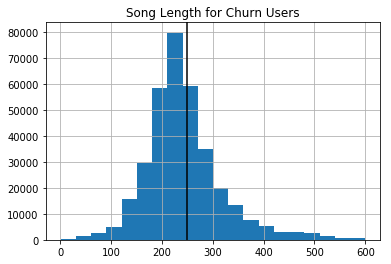

In [50]:
active_length = user_active.where(user_log.length <= 600).select('length').toPandas()
active_length['length'].hist(bins=20)
plt.axvline(x=user_active.agg({"length": "mean"}).collect()[0][0], color='black')
plt.title('Song Length for Churn Users')

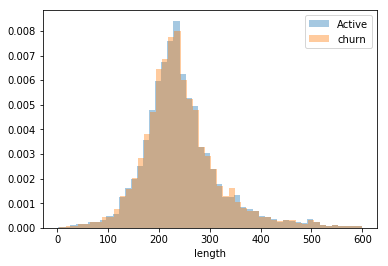

In [51]:
sns.distplot(active_length['length'],  norm_hist=True, kde=False, label='Active')
sns.distplot(churn_length['length'],  norm_hist=True, kde=False, label='churn')
plt.legend()

Virtually the **same** distribution of song length.

### Let's compare distribution of items in session

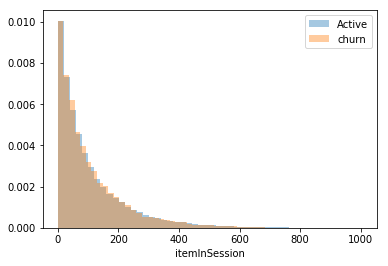

In [52]:
sns.distplot(user_active.select('itemInSession').toPandas()['itemInSession'],  kde=False, norm_hist=True, label='Active')
sns.distplot(user_churn.select('itemInSession').toPandas()['itemInSession'],  kde=False, norm_hist=True, label='churn')
plt.legend()

### Number of distinct sessions (normalized by... number of days?)

In [53]:
user_sessions = user_log.groupby('userId').\
agg(countDistinct('sessionId').alias('sessions'), datediff(max('date'), min('date')).alias('days')).\
withColumn('sessions_per_day', col('sessions')/col('days'))

In [54]:
session_churn = user_sessions.where(col('userId').isin(list(churn_ids))).where(~col('sessions_per_day').isNull()).toPandas()
session_active = user_sessions.where(col('userId').isin(list(no_churn_ids))).where(~col('sessions_per_day').isNull()).toPandas()

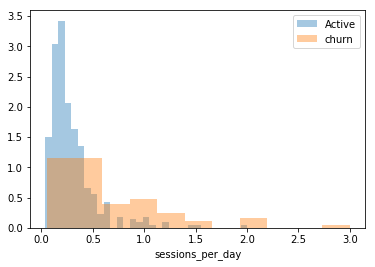

In [55]:
sns.distplot(session_active['sessions_per_day'],  norm_hist=True, kde=False, label='Active')
sns.distplot(session_churn['sessions_per_day'],  norm_hist=True, kde=False, label='churn')
plt.legend()

Here we do see some differences

### Number of songs played by session?

In [56]:
songs_session = user_log.where(col('page')=='NextSong').groupby('userId','sessionId').count()

In [57]:
songs_session.printSchema()

root
 |-- userId: string (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- count: long (nullable = false)



In [58]:
songs_churn = songs_session.where(col('userId').isin(list(churn_ids))).toPandas()
songs_active = songs_session.where(col('userId').isin(list(no_churn_ids))).toPandas()

In [59]:
songs_churn['count'].mean()

72.4733676975945

In [60]:
songs_active['count'].mean()

73.26424216943452

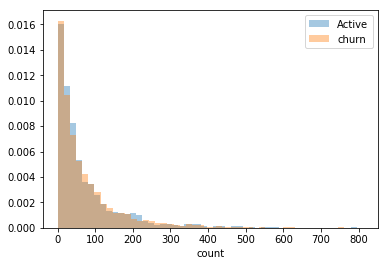

In [61]:
sns.distplot(songs_churn['count'],  norm_hist=True, kde=False, label='Active')
sns.distplot(songs_active['count'],  norm_hist=True, kde=False, label='churn')
plt.legend()

### We have not identifies any really interesting feature so far, besides numbe of sessions per day. By interesting we mean exhibiting clear differences between the classes (churned and not churned). We will then create new features just based on what we think might be predictor of churning, even if we do not have any evidence yet.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [62]:
# we create a list of dataframes with the structure userId, feature, and we will join them at the end using reduce.
listDf = []

### Feature 1: Target, churn

This feature has already been created!

In [63]:
map_user_churn = user_log.groupby(['userId']).agg({"churn": "sum"}).withColumn('churn',col('sum(churn)')).\
select(['userId','churn'])
listDf.append(map_user_churn)

In [64]:
map_user_churn

DataFrame[userId: string, churn: bigint]

### Feature 2: Predictor, Number of times the user has downgraded

In [65]:
flag_downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())

In [66]:
user_log = user_log.withColumn('downgraded', flag_downgrade_event('page'))

In [67]:
map_user_downgrades = user_log.groupby('userId').agg({'downgraded':'sum'}).\
withColumn('number_downgrades',col('sum(downgraded)')).select(['userId','number_downgrades'])
map_user_downgrades

DataFrame[userId: string, number_downgrades: bigint]

In [68]:
listDf.append(map_user_downgrades)

### Feature 3: Predictor, Mean Number of songs played in a session

In [69]:
map_songs_session = user_log.where(col('page')=='NextSong').groupby('userId','sessionId').count()
map_songs_session = map_songs_session.groupby('userId').agg(avg('count').alias('number_songs'))

In [70]:
listDf.append(map_songs_session)

In [71]:
# map_songs_session.orderBy('number_songs').collect()

### Feature 4: Sessions per day

In [72]:
# corrected_date_diff = udf(lambda x: datediff(max(x), min(x)), IntegerType())
map_sessions_day = user_log.groupby('userId').agg(countDistinct('sessionId').alias('sessions'), datediff(max('date'), min('date')).alias('days'))\
.withColumn('sessions_per_day', col('sessions')/(col('days')+1))\
.select(['userId','sessions_per_day'])

listDf.append(map_sessions_day)

In [73]:
map_sessions_day

DataFrame[userId: string, sessions_per_day: double]

### Feature 5: Time since registration

In [74]:
map_since_registration = user_log.groupby('userId').agg(datediff(max('date'), min('registration_date')).alias('since_registration'))

In [75]:
map_since_registration

DataFrame[userId: string, since_registration: int]

In [76]:
listDf.append(map_since_registration)

### Feature 6: Number of thums up and down - as a difference

In [77]:
# difference  of Thumbs-Up/Down
map_thumbs_up = user_log.select('userID','page').where(user_log.page == 'Thumbs Up').groupBy('userID').count().\
withColumnRenamed('count', 'thumbs_up') 
map_thumbs_up.describe().show()

+-------+------------------+-----------------+
|summary|            userID|        thumbs_up|
+-------+------------------+-----------------+
|  count|               439|              439|
|   mean| 67308.81548974942|54.27334851936219|
| stddev|106228.80408254788|69.94135178778987|
|    min|                10|                1|
|    max|                99|              506|
+-------+------------------+-----------------+



In [78]:
map_thumbs_down = user_log.select('userID','page').where(user_log.page == 'Thumbs Down').groupBy('userID')\
.count().withColumnRenamed('count', 'thumbs_down') 
map_thumbs_down.describe().show()

+-------+------------------+------------------+
|summary|            userID|       thumbs_down|
+-------+------------------+------------------+
|  count|               389|               389|
|   mean| 70031.19537275065|12.624678663239074|
| stddev|106895.73735311361|13.582432851937995|
|    min|                10|                 1|
|    max|                99|                80|
+-------+------------------+------------------+



In [79]:
map_likeness = map_thumbs_up.join(map_thumbs_down, on='userId')
map_likeness = map_likeness.withColumn('likeness', map_likeness.thumbs_up - map_likeness.thumbs_down)\
.select(['userId', 'likeness'])

In [80]:
listDf.append(map_likeness)

### Feature 7: Number of songs added to playlists

In [81]:
# Number of songs added to playlist
map_added_playlist = user_log.select('userID','page').where(user_log.page == 'Add to Playlist').\
groupBy('userID').count().withColumnRenamed('count', 'add_to_playlist')

In [82]:
map_added_playlist.describe().show()

+-------+------------------+------------------+
|summary|            userID|   add_to_playlist|
+-------+------------------+------------------+
|  count|               428|               428|
|   mean| 65764.93457943926|28.852803738317757|
| stddev|105363.38578382805|33.913090694566286|
|    min|                10|                 1|
|    max|                99|               248|
+-------+------------------+------------------+



In [83]:
listDf.append(map_added_playlist)

### Feature 8: predictor, Gender

In [84]:
flag_gender = udf(lambda x: 1 if x == "M" else 0, IntegerType())

user_log = user_log.withColumn('gender_coded', flag_gender('gender'))
map_user_gender = user_log.groupby('userId').agg(max('gender_coded').alias('gender'))

In [85]:
map_user_gender

DataFrame[userId: string, gender: int]

In [86]:
# # apart from groupby, you can also process by windows of rows
# windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)
# user_log_valid = user_log_valid.withColumn("phase", Fsum("downgraded").over(windowval))
# user_log_valid.select(["userId", "firstname", "ts", "page", "level", "phase"]).where(user_log.userId == "1138").sort("ts").collect()

In [87]:
listDf.append(map_user_gender)

### At last, bring all together and create a dataframe where each row is a user, and the columns the engineered features

In [88]:
listDf

[DataFrame[userId: string, churn: bigint],
 DataFrame[userId: string, number_downgrades: bigint],
 DataFrame[userId: string, number_songs: double],
 DataFrame[userId: string, sessions_per_day: double],
 DataFrame[userId: string, since_registration: int],
 DataFrame[userId: string, likeness: bigint],
 DataFrame[userID: string, add_to_playlist: bigint],
 DataFrame[userId: string, gender: int]]

In [89]:
df_res = listDf[0]
for df_next in listDf[1:]:
    df_res = df_res.join(df_next,on='userId',how='inner')
df_res = df_res.fillna(0)

In [90]:
df_res.printSchema()

root
 |-- userId: string (nullable = true)
 |-- churn: long (nullable = true)
 |-- number_downgrades: long (nullable = true)
 |-- number_songs: double (nullable = false)
 |-- sessions_per_day: double (nullable = false)
 |-- since_registration: integer (nullable = true)
 |-- likeness: long (nullable = false)
 |-- add_to_playlist: long (nullable = false)
 |-- gender: integer (nullable = true)



In [91]:
df_res.count()

384

That's the number of users we have informatio about

In [92]:
df_res.take(5)

[Row(userId='100010', churn=1, number_downgrades=0, number_songs=48.0, sessions_per_day=0.5, since_registration=14, likeness=1, add_to_playlist=1, gender=0),
 Row(userId='200002', churn=1, number_downgrades=0, number_songs=62.0, sessions_per_day=0.16666666666666666, since_registration=54, likeness=10, add_to_playlist=6, gender=1),
 Row(userId='125', churn=0, number_downgrades=0, number_songs=20.666666666666668, sessions_per_day=0.06666666666666667, since_registration=106, likeness=2, add_to_playlist=2, gender=1),
 Row(userId='124', churn=1, number_downgrades=0, number_songs=114.125, sessions_per_day=0.40476190476190477, since_registration=112, likeness=87, add_to_playlist=45, gender=0),
 Row(userId='51', churn=1, number_downgrades=0, number_songs=53.2, sessions_per_day=0.3125, since_registration=19, likeness=15, add_to_playlist=8, gender=1)]

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

[Differences between pyspark ML and MLLIB](https://intellipaat.com/community/9624/whats-the-difference-between-spark-ml-and-mllib-packages): We will be using pyspark.mllib package, as it is the most recent API. pyspark.mllib is the old one, built on top of RDD.

df_res is out dataframe containing the target (churn) and the engineered features. We will convert the features to a vector using 

assembler = VectorAssembler(inputCols=["DescLength"], outputCol="DescVec")

and then model a simple linearreg on top of that.

In [93]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import LinearSVC

from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler

### Create Vector Assembler

In [94]:
features = [col for col in df_res.columns if col not in ['userId','churn']]
features

['number_downgrades',
 'number_songs',
 'sessions_per_day',
 'since_registration',
 'likeness',
 'add_to_playlist',
 'gender']

In [95]:
assembler = VectorAssembler(inputCols=features, outputCol="featureVec")
df_res = assembler.transform(df_res)

### Select label and feature columns

In [96]:
data = df_res.select(col("churn").alias("label"), col("featureVec").alias("features"))
data.head()

Row(label=1, features=DenseVector([0.0, 48.0, 0.5, 14.0, 1.0, 1.0, 0.0]))

### Split into train and test set

In [97]:
# MODEL SELECTION AND TUNING
# split dataset into train and test
train, test = data.randomSplit([0.8, 0.2], seed=42)

**Remember:** Even though we have only split into train and test set, train will be further split through the use of crossvalidation, and test will be only used once, after we have tuned our different choices of algorithms for a final evaluation on performance.

## Cross-validation

Cross validation will be performed to get a better sense of the performance of these three algorithms: Logistic Regression, SVM and GBT. The chosen metric to assess this is F1-score, since we have kind of an unbalanced dataset, and therefore we care both about Precision and Recall, rather than Accuracy or plain ROC-AUC.

### Logistic Regression

In [98]:
# initialize classifier
log = LogisticRegression()

# set evaluator
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')


# build paramGrid
paramGrid = ParamGridBuilder().addGrid(log.maxIter,[5, 10]).addGrid(log.regParam,[0.5, 0.9]).build()

crossval_log = CrossValidator(estimator=log,
                          evaluator=f1_evaluator, 
                          estimatorParamMaps=paramGrid,
                          numFolds=2)

In [99]:
start = time()
cvModel_log = crossval_log.fit(train)
end = time()

In [100]:
print('The training process took {} seconds'.format(end - start))
print(cvModel_log.avgMetrics)

The training process took 854.6084489822388 seconds
[0.685193107094953]


### SVM

In [101]:
# initialize classifier
svc = LinearSVC()

# set evaluator
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

# build paramGrid
paramGrid = ParamGridBuilder().addGrid(svc.maxIter,[5, 10]).addGrid(svc.regParam,[0.5,0.9]).build()


crossval_svc = CrossValidator(estimator=svc,
                          evaluator=f1_evaluator, 
                          estimatorParamMaps=paramGrid,
                          numFolds=2)

In [102]:
start = time()
cvModel_svc = crossval_svc.fit(train)
end = time()

In [103]:
print('The training process took {} seconds'.format(end - start))
print(cvModel_svc.avgMetrics)

The training process took 899.5735673904419 seconds
[0.6782509421947]


### Gradient Boosting Machines

In [104]:
# initialize classifier
gbt = GBTClassifier()

# set evaluator
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

# build paramGrid
paramGrid = ParamGridBuilder().addGrid(gbt.maxDepth,[5, 10]).build()


crossval_gbt = CrossValidator(estimator=gbt,
                          evaluator=f1_evaluator, 
                          estimatorParamMaps=paramGrid,
                          numFolds=2)

In [105]:
start = time()
cvModel_gbt = crossval_gbt.fit(train)
end = time()

In [106]:
print('The training process took {} seconds'.format(end - start))
print(cvModel_gbt.avgMetrics)

The training process took 1682.9717593193054 seconds
[0.7685299251451683]


# Evaluation on Test

In [129]:
predictions = cvModel_gbt.bestModel.transform(test)

In [139]:
# predictions.collect()

In [131]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.7995642701525055


In [132]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Model_gbt Metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(predictions, {evaluator.metricName: "f1"})))

Model_gbt Metrics:
Accuracy: 0.8591549295774648
F-1 Score:0.8423431837710613


### Feature importance from GBT

In [133]:
bestmodel_gbt = cvModel_gbt.bestModel
bestmodel_gbt.extractParamMap()

{Param(parent='GBTClassifier_caf21f33b127', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False,
 Param(parent='GBTClassifier_caf21f33b127', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10,
 Param(parent='GBTClassifier_caf21f33b127', name='featureSubsetStrategy', doc='The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n].'): 'all',
 Param(parent='GBTClassifier_caf21f33b127', name='featuresCol', doc='features column name'): 'features',
 Param(parent='GBTClassifier_caf21f33b127', name='labelCol', doc='label column name'): 'la

In [187]:
feat_imp = bestmodel_gbt.featureImportances.values
cols = features
y_pos = np.arange(len(cols))

In [188]:
list(zip(y_pos, features, feat_imp))

[(0, 'number_downgrades', 0.057525951185347646),
 (1, 'number_songs', 0.22303021104482917),
 (2, 'sessions_per_day', 0.20538580022347022),
 (3, 'since_registration', 0.19746365649432415),
 (4, 'likeness', 0.18938443469776894),
 (5, 'add_to_playlist', 0.12011482908729103),
 (6, 'gender', 0.007095117266968846)]

In [189]:
feat_imp_sort = [feat_imp[i] for i in np.argsort(feat_imp)]

In [190]:
col_sort = [features[i] for i in np.argsort(feat_imp)]

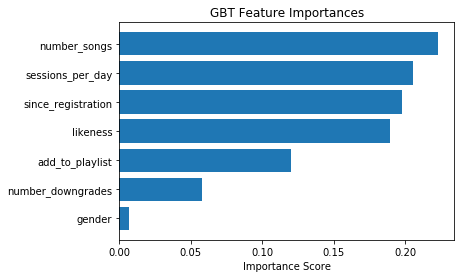

In [191]:
plt.barh(y_pos,feat_imp_sort)
plt.yticks(y_pos, col_sort)
plt.xlabel('Importance Score')
plt.title('GBT Feature Importances');

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.